<a href="https://colab.research.google.com/github/luthra2059/Clustering-Geolocation-Data-Intelligently-in-Python/blob/master/Clustering_Geolocation_Data_Intelligently_in_Python.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
%config InlineBackend.figure_format = 'svg'
plt.style.use('ggplot')
import pandas as pd
import numpy as np
from tqdm import tqdm
from sklearn.cluster import KMeans, DBSCAN
from sklearn.metrics import silhouette_score
from sklearn.datasets import make_blobs
from sklearn.neighbors import KNeighborsClassifier
from ipywidgets import interactive
from collections import defaultdict
!pip install --upgrade pip
!pip install numpy>=1.16.0
!pip install Cython
!pip install hdbscan
import hdbscan
import folium
import re
cols = ['#e6194b', '#3cb44b', '#ffe119', '#4363d8', '#f58231', '#911eb4',
        '#46f0f0', '#f032e6', '#bcf60c', '#fabebe', '#008080', '#e6beff', 
        '#9a6324', '#fffac8', '#800000', '#aaffc3', '#808000', '#ffd8b1', 
        '#000075', '#808080']*10

     |████████████████████████████████| 1.5MB 2.6MB/s 
  Found existing installation: pip 19.3.1
    Uninstalling pip-19.3.1:
      Successfully uninstalled pip-19.3.1
     |████████████████████████████████| 4.7 MB 61 kB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
  Created wheel for hdbscan: filename=hdbscan-0.8.26-cp36-cp36m-linux_x86_64.whl size=2308501 sha256=82c2cd7535fe8b7341d7a51bbe9718fd9d08ebf39296fa639b34bb9c5fe78bf6
  Stored in directory: /root/.cache/pip/wheels/36/20/d1/521b2fbf637de5bc40668b6445944e7e44bfbe68fdaa65157d
Successfully built hdbscan


In [2]:
df = pd.read_csv('drive/My Drive/datasets/geolocation/taxi_data.csv')

**Exploratory Data Analysis**

In [3]:
df.head()

LON       LAT                          NAME
0  28.17858 -25.73882         11th Street Taxi Rank
1  28.17660 -25.73795    81 Bazaar Street Taxi Rank
2  27.83239 -26.53722          Adams Road Taxi Rank
3  28.12514 -26.26666  Alberton City Mall Taxi Rank
4  28.10144 -26.10567      Alexandra Main Taxi Rank

In [4]:
df.duplicated(subset=['LON', 'LAT'])

0      False
1      False
2      False
3      False
4      False
       ...  
833    False
834    False
835    False
836    False
837    False
Length: 838, dtype: bool

In [6]:
df.duplicated(subset=['LON', 'LAT']).values.any()

True

In [7]:
df.isna().values.any()

True

In [8]:
df.dropna(inplace=True)

In [9]:
df.drop_duplicates(subset=['LON','LAT'], keep='first', inplace=True)

In [10]:
df.shape

(823, 3)

In [11]:
df.head()

LON       LAT                          NAME
0  28.17858 -25.73882         11th Street Taxi Rank
1  28.17660 -25.73795    81 Bazaar Street Taxi Rank
2  27.83239 -26.53722          Adams Road Taxi Rank
3  28.12514 -26.26666  Alberton City Mall Taxi Rank
4  28.10144 -26.10567      Alexandra Main Taxi Rank

In [12]:
X = np.array(df[['LON','LAT']], dtype='float64')

In [13]:
X

array([[ 28.17858, -25.73882],
       [ 28.1766 , -25.73795],
       [ 27.83239, -26.53722],
       ...,
       [ 27.83991, -26.24235],
       [ 27.86166, -26.23624],
       [ 28.39097, -26.30931]])

**Visulaizing Geographical Data**

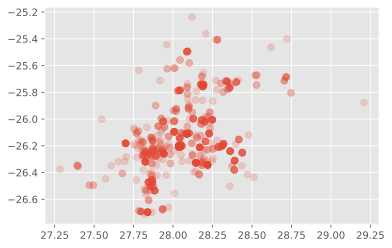

In [14]:
plt.scatter(X[:,0], X[:, 1], alpha=0.2, s=50)

In [18]:
m = folium.Map(location=[df.LAT.mean(), df.LON.mean()], zoom_start=9, tiles='Stamen Toner')

In [19]:
m

In [22]:
for _, row in df.iterrows():
  folium.CircleMarker(
      location=[row.LAT, row.LON],
      radius=5,
      popup=re.sub(r'[^a-zA-Z]+', '', row.NAME),
      color = '#1787FE',
      fill=True,
      fill_colour = '#1787FE'
  ).add_to(m)

In [23]:
m

**Clustering Strength/Performance**

In [24]:
X_blobs, _ = make_blobs(n_samples=1000, centers=10, n_features=2, cluster_std=0.5, random_state=4)

In [26]:
X_blobs[:, 0]

array([ -6.89867307,  -9.73185423,  -5.37043025,  -5.42314701,
         9.2442018 ,   7.83653481,   3.69089919,   8.06230342,
        -8.98026555,   8.93959345, -10.44510642,   3.6997984 ,
        -8.68499691,   9.4920478 ,  -7.5247303 ,   5.62510128,
         3.6346133 ,   4.01981664,   5.88767288,   5.82394119,
        -9.63945246,   9.81794608,  -5.72808176,   9.05698115,
        -7.02408198,   6.04769515,  -9.04977283,   6.54300942,
         8.92894373,   4.52506605,  -6.95415549,   4.47432842,
         9.95520348,  -4.75566026,  10.43804689,  -8.70337564,
        -4.59723164,   4.36810817,   5.25617623,   9.95052909,
         9.35868628,  -9.66869588,  -5.32002898,  -8.88182853,
       -10.50274264,   4.36352576,  -4.57109282,   6.60861612,
         6.44193293,  -9.99885414,   9.08096798,  -4.85535978,
         9.62356889,   3.50418602,   5.17698804, -10.55327853,
        -9.25313334,  -7.08867465, -10.48200056,  -4.76416269,
         9.09915744,   9.3645999 ,  -9.26901151,  -4.96

In [25]:
plt.scatter(X_blobs[:,0], X_blobs[:,1], alpha=0.2)

In [27]:
class_predictions = np.load('drive/My Drive/datasets/geolocation/sample_clusters.npy')

In [28]:
class_predictions

array([2, 2, 2, 2, 1, 0, 1, 0, 2, 1, 2, 1, 2, 0, 2, 1, 1, 1, 1, 1, 2, 0,
       2, 0, 2, 1, 2, 0, 0, 1, 2, 1, 0, 2, 0, 2, 2, 1, 1, 0, 0, 2, 2, 2,
       2, 1, 2, 1, 0, 2, 1, 2, 1, 1, 1, 2, 2, 2, 2, 2, 0, 0, 2, 2, 1, 0,
       2, 2, 0, 1, 2, 2, 0, 2, 2, 2, 0, 0, 1, 2, 1, 2, 0, 2, 2, 1, 2, 2,
       1, 2, 2, 0, 2, 1, 2, 2, 1, 0, 2, 2, 2, 0, 1, 0, 1, 2, 0, 0, 2, 2,
       0, 2, 0, 1, 2, 1, 1, 1, 1, 2, 1, 1, 0, 2, 0, 1, 1, 2, 1, 2, 0, 0,
       2, 0, 1, 1, 0, 2, 0, 0, 0, 0, 2, 1, 0, 2, 2, 2, 2, 0, 0, 2, 0, 2,
       1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 2, 2, 0, 2, 0, 2,
       2, 0, 1, 2, 1, 1, 2, 0, 1, 1, 2, 1, 2, 0, 2, 1, 0, 2, 2, 2, 0, 2,
       1, 2, 2, 2, 1, 2, 2, 1, 2, 2, 2, 0, 1, 2, 2, 1, 1, 2, 2, 0, 2, 0,
       2, 1, 0, 2, 0, 2, 1, 0, 0, 0, 2, 2, 2, 1, 2, 1, 0, 0, 1, 0, 2, 1,
       1, 2, 0, 2, 0, 2, 2, 1, 0, 0, 0, 1, 1, 2, 1, 1, 0, 0, 1, 0, 2, 2,
       1, 0, 2, 1, 0, 0, 2, 1, 2, 1, 0, 0, 2, 2, 2, 0, 1, 0, 1, 0, 2, 1,
       0, 1, 1, 0, 1, 0, 1, 2, 2, 2, 0, 0, 1, 2, 0,

In [29]:
unique_clusters = np.unique(class_predictions)
for unique_clusters in unique_clusters:
  X = X_blobs[class_predictions==unique_clusters]
  plt.scatter(X[:,0],X[:,1], alpha=0.2, c=cols[unique_clusters])

In [30]:
silhouette_score(X_blobs, class_predictions)

0.6657220862867241

In [31]:
class_predictions = np.load('drive/My Drive/datasets/geolocation/sample_clusters_improved.npy')

In [32]:
unique_clusters = np.unique(class_predictions)
for unique_cluster in unique_clusters:
    X = X_blobs[class_predictions==unique_cluster]
    plt.scatter(X[:,0], X[:,1], alpha=0.2, c=cols[unique_cluster])

In [33]:
silhouette_score(X_blobs, class_predictions)

0.7473587799908298

**K-Means Clustering**

In [34]:
X_blobs, _ = make_blobs(n_samples=1000, centers=50, n_features=2, cluster_std=1, random_state=4)

In [35]:
data = defaultdict(dict)
for x in range(1, 21):
  model = KMeans(n_clusters=3, random_state=17, max_iter=x, n_init=1).fit(X_blobs)
  data[x]['class_predictions'] = model.predict(X_blobs)
  data[x]['centroids'] = model.cluster_centers_
  data[x]['unique_classes'] = np.unique(class_predictions)

In [36]:
def f(x):
    class_predictions = data[x]['class_predictions']
    centroids = data[x]['centroids']
    unique_classes = data[x]['unique_classes']

    for unique_class in unique_classes:
            plt.scatter(X_blobs[class_predictions==unique_class][:,0], 
                        X_blobs[class_predictions==unique_class][:,1], 
                        alpha=0.3, c=cols[unique_class])
    plt.scatter(centroids[:,0], centroids[:,1], s=200, c='#000000', marker='v')
    plt.ylim([-15,15]); plt.xlim([-15,15])
    plt.title('How K-Means Clusters')

interactive_plot = interactive(f, x=(1, 20))
output = interactive_plot.children[-1]
output.layout.height = '350px'
interactive_plot

interactive(children=(IntSlider(value=10, description='x', max=20, min=1), Output(layout=Layout(height='350px'…

In [37]:
X = np.array(df[['LON', 'LAT']], dtype='float64')
k = 70
model = KMeans(n_clusters=k, random_state=17).fit(X)
class_predictions = model.predict(X)
df[f'CLUSTER_kmeans{k}'] = class_predictions

In [38]:
df.head()

LON       LAT                          NAME  CLUSTER_kmeans70
0  28.17858 -25.73882         11th Street Taxi Rank                15
1  28.17660 -25.73795    81 Bazaar Street Taxi Rank                15
2  27.83239 -26.53722          Adams Road Taxi Rank                 5
3  28.12514 -26.26666  Alberton City Mall Taxi Rank                33
4  28.10144 -26.10567      Alexandra Main Taxi Rank                18

In [54]:
def create_map(df, cluster_column):
    m = folium.Map(location=[df.LAT.mean(), df.LON.mean()], zoom_start=9, tiles='Stamen Toner')

    for _, row in df.iterrows():

      if row[cluster_column] == -1:
          cluster_colour = '#000000'
      else:
          cluster_colour = cols[row[cluster_column]]

        
      folium.CircleMarker(
        location=[row['LAT'], row['LON']],
        radius=5,
        popup=re.sub(r'[^a-zA-Z]+', '', row.NAME),
        color = cluster_colour,
        fill=True,
        fill_colour = cluster_colour
      ).add_to(m)
       
    return m
    
m = create_map(df, 'CLUSTER_kmeans70')
print(f'K={k}')
print(f'Silhouette Score: {silhouette_score(X, class_predictions)}')

m.save('kmeans_70.html')

K=70
Silhouette Score: 0.6367300948961482


In [55]:
m

In [56]:
best_silhouette, best_k = -1, 0

for k in tqdm(range(2, 100)):
    model = KMeans(n_clusters=k, random_state=1).fit(X)
    class_predictions = model.predict(X)
    
    curr_silhouette = silhouette_score(X, class_predictions)
    if curr_silhouette > best_silhouette:
        best_k = k
        best_silhouette = curr_silhouette
        
print(f'K={best_k}')
print(f'Silhouette Score: {best_silhouette}') 

100%|██████████| 98/98 [00:29<00:00,  3.27it/s]

K=98
Silhouette Score: 0.6971995093340411


**DBSCAN**

In [57]:
dummy = np.array([-1, -1, -1, 2, 3, 4, 5, -1])
new = np.array([(counter+2)*x if x==-1 else x for counter, x in enumerate(dummy)])

In [58]:
new

array([-2, -3, -4,  2,  3,  4,  5, -9])

In [59]:
model = DBSCAN(eps=0.01, min_samples=5).fit(X)
class_predictions = model.labels_

df['CLUSTERS_DBSCAN'] = class_predictions

In [60]:
df.head()

LON       LAT  ... CLUSTER_kmeans70  CLUSTERS_DBSCAN
0  28.17858 -25.73882  ...               15                0
1  28.17660 -25.73795  ...               15                0
2  27.83239 -26.53722  ...                5               -1
3  28.12514 -26.26666  ...               33               -1
4  28.10144 -26.10567  ...               18                1

[5 rows x 5 columns]

In [61]:
m = create_map(df, 'CLUSTERS_DBSCAN')

    
print(f'Number of clusters found: {len(np.unique(class_predictions))}')
print(f'Number of outliers found: {len(class_predictions[class_predictions==-1])}')

print(f'Silhouette ignoring outliers: {silhouette_score(X[class_predictions!=-1], class_predictions[class_predictions!=-1])}')

no_outliers = 0
no_outliers = np.array([(counter+2)*x if x==-1 else x for counter, x in enumerate(class_predictions)])
print(f'Silhouette outliers as singletons: {silhouette_score(X, no_outliers)}')

Number of clusters found: 51
Number of outliers found: 289
Silhouette ignoring outliers: 0.9232138250288208
Silhouette outliers as singletons: 0.5667489350583482


In [63]:
m

**HDBSCAN**

In [64]:
model = hdbscan.HDBSCAN(min_cluster_size=5, min_samples=2, 
                        cluster_selection_epsilon=0.01)

In [65]:
class_predictions = model.fit_predict(X)
df['CLUSTER_HDBSCAN'] = class_predictions

In [66]:
m = create_map(df, 'CLUSTER_HDBSCAN')

print(f'Number of clusters found: {len(np.unique(class_predictions))-1}')
print(f'Number of outliers found: {len(class_predictions[class_predictions==-1])}')

print(f'Silhouette ignoring outliers: {silhouette_score(X[class_predictions!=-1], class_predictions[class_predictions!=-1])}')

no_outliers = np.array([(counter+2)*x if x==-1 else x for counter, x in enumerate(class_predictions)])
print(f'Silhouette outliers as singletons: {silhouette_score(X, no_outliers)}')

m

Number of clusters found: 66
Number of outliers found: 102
Silhouette ignoring outliers: 0.7670504356844786
Silhouette outliers as singletons: 0.638992483305273


**ADDRESSING OUTLIERS**

In [67]:
classifier = KNeighborsClassifier(n_neighbors=1)

In [68]:
df_train = df[df.CLUSTER_HDBSCAN!=-1]
df_predict = df[df.CLUSTER_HDBSCAN==-1]

In [77]:
X_train = np.array(df_train[['LON', 'LAT']], dtype='float64')
y_train = np.array(df_train['CLUSTER_HDBSCAN'])

X_predict = np.array(df_predict[['LON', 'LAT']], dtype='float64')

In [78]:
classifier.fit(X_train, y_train)
predictions = classifier.predict(X_predict)

In [79]:
print(predictions)
df['CLUSTER_hybrid'] = df['CLUSTER_HDBSCAN']

[26 41 13 44 57 26 34  4 60 60 16 16 61 24 51 51 51 58 41 63 13 45 15 45
 45  6  0 17 26 26 26 49 49 53 49 13 61 26 26 39 65 31 31 31  0 46 46 21
 58 60  6  5 24  1 63 34 64 36 36 16  7  3 64 41 13 39 39 39 41 40 40 25
 59 57 61 61 62 26 15 15 59 63  6 19 61 61 48  4 41 21 64 64 64 61 61 21
 23 38 31 41 55 55]


In [80]:
df.loc[df.CLUSTER_HDBSCAN==-1, 'CLUSTER_hybrid'] = predictions

In [81]:
m = create_map(df, 'CLUSTER_hybrid')

In [82]:
m

In [83]:
class_predictions = df.CLUSTER_hybrid
print(f'Number of clusters found: {len(np.unique(class_predictions))}')
print(f'Silhouette: {silhouette_score(X, class_predictions)}')

m.save('hybrid.html')

Number of clusters found: 66
Silhouette: 0.5849126494706486


Text(0.5, 0, 'Cluster Sizes')

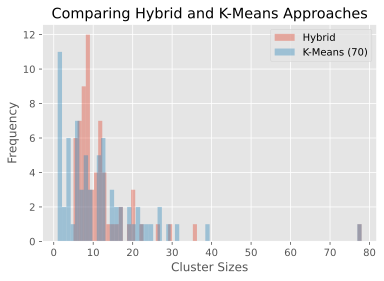

In [84]:
df['CLUSTER_hybrid'].value_counts().plot.hist(bins=70, alpha=0.4, 
                                              label='Hybrid')
df['CLUSTER_kmeans70'].value_counts().plot.hist(bins=70, alpha=0.4,
                                               label='K-Means (70)')
plt.legend()
plt.title('Comparing Hybrid and K-Means Approaches')
plt.xlabel('Cluster Sizes')